## Test modules during dev


In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
import sys
sys.path.append('../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes

2024-09-29 18:12:03.312387: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 18:12:03.312422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 18:12:03.313732: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
#dtree = datasets.read_filtered_datatree()
#dtree = datasets.calculate_magnitudes(dtree)

## Load data for different simulations and prepare it with right variables and non-dims.

In this step all the variables and extra dimensions may be created that were not originally present. 
Each input and output variable gets its own containing variable (e.g. if top and bottom layer were two separate inputs, then in this step they may get separated out). 
Other examples might be that rotated variables, or magnitudes become their own variables in this step. 

In [6]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=['P2L'], filter_scales=['50','100','200','400'])

Initializing data sequence.


In [7]:
DT.preprocess_simulation_data(window_size=3)

In [8]:
DT.simulation_data

DataTree('None', parent=None)
└── DataTree('P2L')
    ├── DataTree('50')
    │       Dimensions:                      (Time: 7200, xh: 150, yh: 200, zl: 2, Xn: 3,
    │                                         Yn: 3, zi: 3)
    │       Coordinates:
    │         * Time                         (Time) object 58kB 0001-01-11 00:00:00 ... 0...
    │         * xh                           (xh) float64 1kB 4.0 12.0 ... 1.196e+03
    │         * yh                           (yh) float64 2kB 4.0 12.0 ... 1.596e+03
    │         * zl                           (zl) float64 16B 1.031e+03 1.033e+03
    │         * zi                           (zi) float64 24B 1.03e+03 1.032e+03 1.034e+03
    │       Dimensions without coordinates: Xn, Yn
    │       Data variables: (12/40)
    │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           ...                           ...
    │           dvdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dvdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dhdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dhdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           uphp_rotated_nondim          (Time, zl, yh, xh) float64 3GB dask.array<chunksize=(36, 2, 199, 149), meta=np.ndarray>
    │           vphp_rotated_nondim          (Time, zl, yh, xh) float64 3GB dask.array<chunksize=(36, 2, 199, 149), meta=np.ndarray>
    │       Attributes:
    │           simulation_name:  P2L
    │           filter_scale:     50
    │           source:           gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/r...
    │           description:      Dataset for P2L experiment at 50 km resolution
    ├── DataTree('100')
    │       Dimensions:                      (Time: 7200, xh: 60, yh: 80, zl: 2, Xn: 3,
    │                                         Yn: 3, zi: 3)
    │       Coordinates:
    │         * Time                         (Time) object 58kB 0001-01-11 00:00:00 ... 0...
    │         * xh                           (xh) float64 480B 10.0 30.0 ... 1.19e+03
    │         * yh                           (yh) float64 640B 10.0 30.0 ... 1.59e+03
    │         * zl                           (zl) float64 16B 1.031e+03 1.033e+03
    │         * zi                           (zi) float64 24B 1.03e+03 1.032e+03 1.034e+03
    │       Dimensions without coordinates: Xn, Yn
    │       Data variables: (12/40)
    │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(36, 2, 79, 59, 3, 3), meta=np.ndarray>
    │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(36, 2, 79, 59, 3, 3), meta=np.ndarray>
    │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(36, 2, 79, 59, 3, 3), meta=np.ndarray>
   

## ML data
Go from simulation data to batches. 
In this step things like dropping extra points, masking of data etc happen. 

In [21]:
all_ml_variables = ['dudx_widened',  
                    'dvdx_widened', 
                    'dudy_widened',
                    'dvdy_widened',
                    'dhdx_widened',
                    'dhdy_widened',
                    'filter_scale', 
                    'uphp',
                    'vphp']

# inputs = ['dudx',  
#           'dvdx', 
#           'dudy',
#           'dvdy',
#           'dhdx',
#           'dhdy',
#           'filter_scale']

inputs =  ['dudx_widened',  
                    'dvdx_widened', 
                    'dudy_widened',
                    'dvdy_widened',
                    'dhdx_widened',
                    'dhdy_widened',
                    'filter_scale']
outputs = ['uphp','vphp']


In [ ]:

ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, all_ml_variables=all_ml_variables,
                                  time_range=slice(0, 64))
ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT,all_ml_variables=all_ml_variables,
                                  time_range=slice(-32, None))

In [12]:
ML_DT_train.create_xr_ML_variables(37)

choose_ml_variables took: 0.0020 seconds
Time subsampling took: 0.0132 seconds
Horizontal subsampling took: 0.0097 seconds
h_mask_ml_variables took: 0.0840 seconds
stack_physical_dimensions took: 0.0341 seconds
will load upto: 0.085888 gb
load took: 1.3331 seconds
drop_nans took: 0.0627 seconds
Seed set as:42
randomize_along_points took: 0.0736 seconds
Picked: 29952points
pick_uniform_points took: 0.0035 seconds
concat_datatree_nodes took: 0.0263 seconds
randomize_concatenated_ml_dataset took: 0.0444 seconds
generate_batches took: 0.0001 seconds


In [13]:
ML_DT_test.create_xr_ML_variables(5)

choose_ml_variables took: 0.0020 seconds
Time subsampling took: 0.0128 seconds
Horizontal subsampling took: 0.0096 seconds
h_mask_ml_variables took: 0.0776 seconds
stack_physical_dimensions took: 0.0297 seconds
will load upto: 0.042944 gb
load took: 1.5978 seconds
drop_nans took: 0.0250 seconds
Seed set as:42
randomize_along_points took: 0.0267 seconds
Picked: 14976points
pick_uniform_points took: 0.0035 seconds
concat_datatree_nodes took: 0.0115 seconds
randomize_concatenated_ml_dataset took: 0.0199 seconds
generate_batches took: 0.0000 seconds


In [14]:
len(ML_DT_train.ml_batches), len(ML_DT_test.ml_batches) 

(37, 5)

In [15]:
print(len(ML_DT_train.ml_batches[0].points))
print(len(ML_DT_test.ml_batches[0].points))

3238
11980


### Convert these xbatcher batches to processed ones for training

This needs to take care of extra dims, like Xn,Yn.

In [16]:
import jax.numpy as jnp

In [17]:
batch_xr = ML_DT_train.ml_batches[0]

In [18]:
batch_xr

<xarray.Dataset> Size: 2MB
Dimensions:       (Xn: 3, Yn: 3, points: 3238)
Coordinates:
  * points        (points) object 26kB MultiIndex
  * Time          (points) object 26kB 0002-05-16 00:00:00 ... 0001-06-10 00:...
  * xh            (points) float64 26kB 1e+03 1.13e+03 740.0 ... 890.0 570.0
  * yh            (points) float64 26kB 1e+03 330.0 420.0 ... 1.29e+03 410.0
  * zl            (points) float64 26kB 1.031e+03 1.033e+03 ... 1.031e+03
Dimensions without coordinates: Xn, Yn
Data variables:
    dudx_widened  (Xn, Yn, points) float64 233kB -2.067e-07 ... 1.631e-07
    dvdx_widened  (Xn, Yn, points) float64 233kB 1.091e-06 ... 1.103e-06
    dudy_widened  (Xn, Yn, points) float64 233kB -1.447e-06 ... 4.493e-07
    dvdy_widened  (Xn, Yn, points) float64 233kB 1.476e-07 ... -1.654e-07
    dhdx_widened  (Xn, Yn, points) float64 233kB -0.0005435 ... 0.0001012
    dhdy_widened  (Xn, Yn, points) float64 233kB -0.0006344 ... -0.0004147
    filter_scale  (points) float64 26kB 4e+05 1e+05 2e+05 ... 2e+05 1e+05 1e+05
    uphp          (points) float32 13kB 11.05 0.05093 -0.1771 ... 0.178 -0.1921
    vphp          (points) float32 13kB 0.4038 -0.01441 ... 0.01943 0.1242
Attributes:
    simulation_name:  P2L
    filter_scale:     50
    source:           gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/r...
    description:      Dataset for P2L experiment at 50 km resolution

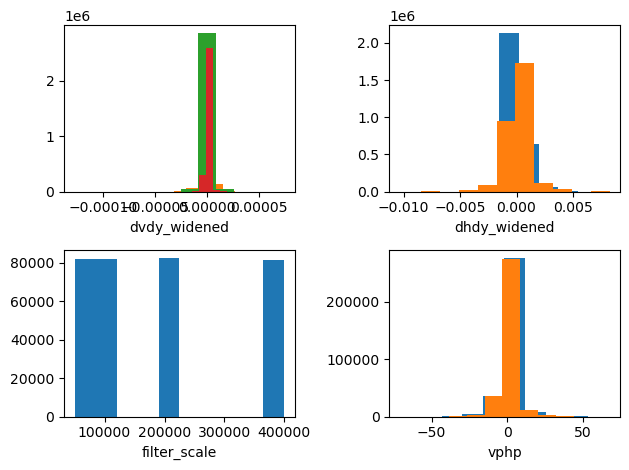

In [17]:
plt.subplot(221)
batch_xr[inputs[0]].plot.hist();
batch_xr[inputs[1]].plot.hist();
batch_xr[inputs[2]].plot.hist();
batch_xr[inputs[3]].plot.hist();

plt.subplot(222)
batch_xr[inputs[4]].plot.hist();
batch_xr[inputs[5]].plot.hist();

plt.subplot(223)
batch_xr[inputs[6]].plot.hist();

plt.subplot(224)
batch_xr.uphp.plot.hist();
batch_xr.vphp.plot.hist();

plt.tight_layout()

In [19]:
# Define the variables and assign normalizations 
normalize_data_dic = {
    'dudx': ([], 1e-6),  # scalar value
    'dvdx': ([], 1e-6),
    'dudy': ([], 1e-6),
    'dvdy': ([], 1e-6),
    'dhdx': ([], 1e-3),
    'dhdy': ([], 1e-3),
    'filter_scale': ([], 140e3),
    'uphp': ([], 4.),
    'vphp': ([], 4.),
    'dudx_widened': ([], 1e-6),  # scalar value
    'dvdx_widened': ([], 1e-6),
    'dudy_widened': ([], 1e-6),
    'dvdy_widened': ([], 1e-6),
    'dhdx_widened': ([], 1e-3),
    'dhdy_widened': ([], 1e-3),
}

ds_norm = xr.Dataset(normalize_data_dic)

In [58]:
inputs

['dudx_widened',
 'dvdx_widened',
 'dudy_widened',
 'dvdy_widened',
 'dhdx_widened',
 'dhdy_widened',
 'filter_scale']

In [76]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, input_channels=inputs, output_channels=outputs, coeff_channels=['filter_scale','filter_scale'])
test_ML_data = datasets.MLJAXDataset(ML_DT_test, input_channels=inputs, output_channels=outputs)

In [77]:
train_ML_data.preprocessed_data[0]['Xp']

Array([[1.6e+11],
       [1.0e+10],
       [4.0e+10],
       ...,
       [4.0e+10],
       [1.0e+10],
       [1.0e+10]], dtype=float32)

In [74]:
(train_ML_data.preprocessed_data[0]['Xp'] * train_ML_data.preprocessed_data[0]['y']).shape

(3238, 2)

In [67]:
train_ML_data.preprocessed_data[0]['y'].shape

(3238, 2)

In [69]:
train_ML_data.preprocessed_data[0]['X_xr']

<xarray.DataArray 'dudx_widened' (points: 3238, input_features: 55)> Size: 1MB
array([[-2.06658017e-07, -6.69582037e-07, -6.66729367e-07, ...,
        -2.27211374e-04, -1.27707889e-04,  4.00000000e+05],
       [ 2.02301360e-07,  2.40914919e-07,  2.89560226e-07, ...,
         2.49418361e-04,  2.44943467e-04,  1.00000000e+05],
       [ 7.71225106e-11,  1.99833767e-11, -2.91775253e-10, ...,
        -1.47438294e-04, -2.12823394e-04,  2.00000000e+05],
       ...,
       [ 4.91106678e-07,  3.37002662e-07,  6.94242690e-08, ...,
        -6.54298740e-04, -4.49642598e-04,  2.00000000e+05],
       [ 1.56332126e-07, -1.66598686e-08, -1.14564761e-07, ...,
        -1.30099415e-04, -3.49533035e-04,  1.00000000e+05],
       [ 4.54426808e-07,  6.57739186e-07,  6.83099872e-07, ...,
        -3.45613260e-04, -4.14739870e-04,  1.00000000e+05]])
Coordinates:
  * points          (points) object 26kB MultiIndex
  * Time            (points) object 26kB 0002-05-16 00:00:00 ... 0001-06-10 0...
  * xh              (points) float64 26kB 1e+03 1.13e+03 740.0 ... 890.0 570.0
  * yh              (points) float64 26kB 1e+03 330.0 420.0 ... 1.29e+03 410.0
  * zl              (points) float64 26kB 1.031e+03 1.033e+03 ... 1.031e+03
  * input_features  (input_features) object 440B MultiIndex
  * variable        (input_features) <U12 3kB 'dudx_widened' ... 'filter_scale'
  * Xn              (input_features) object 440B 0 0 0 1 1 1 2 ... 1 1 2 2 2 nan
  * Yn              (input_features) object 440B 0 1 2 0 1 2 0 ... 1 2 0 1 2 nan

In [29]:
len(train_ML_data.preprocessed_data), len(test_ML_data.preprocessed_data)

(37, 5)

In [30]:
for batch_out in train_ML_data.get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (3238, 55)
Output (y) batch shape: (3238, 2)


In [31]:
for batch_out in test_ML_data.get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (11980, 55)
Output (y) batch shape: (11980, 2)


In [26]:
train_ML_data.get_batches()

<generator object MLData.get_batches at 0x7bba457dcd00>

In [27]:
ML_data_combo = {'train_gen':train_ML_data, 'test_gen':test_ML_data}

In [28]:
ML_data_combo

{'train_gen': <__main__.MLData at 0x7bba13c5f140>,
 'test_gen': <__main__.MLData at 0x7bb999b77290>}

In [29]:
for batch_out in ML_data_combo['train_gen'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (327852, 55)
Output (y) batch shape: (327852, 2)


In [55]:
batch_out

{'X': Array([[-7.2341851e-07, -3.7253852e-07, -4.7278135e-07, ...,
          2.1661326e-04,  1.4236511e-04,  2.0000000e+05],
        [ 2.6875455e-07,  2.7453231e-09, -1.2750785e-06, ...,
         -1.3560626e-04,  7.8975772e-03,  2.0000000e+05],
        [ 1.4173446e-06,  1.4903447e-06,  1.6250965e-06, ...,
          5.2628084e-03,  4.7983197e-03,  5.0000000e+04],
        ...,
        [ 8.0310843e-07,  1.5440262e-06,  2.2080230e-06, ...,
         -1.3536641e-03, -1.9555481e-03,  2.0000000e+05],
        [ 1.9516099e-06,  6.3267754e-07, -3.1863041e-07, ...,
         -3.7036676e-04, -2.0102379e-04,  1.0000000e+05],
        [-8.9124956e-09,  7.1191067e-08,  4.7438476e-08, ...,
          1.6713151e-04,  1.1329831e-04,  4.0000000e+05]], dtype=float32),
 'y': Array([[ -1.8023388 ,   1.5709915 ],
        [  0.36625332,  -0.33403954],
        [  0.5848995 ,  -2.6287792 ],
        ...,
        [-18.444365  ,  11.3821745 ],
        [  0.6926556 ,   0.19947912],
        [  1.0608497 ,   0.08334823]]

In [46]:
temp_xp = batch_xr['vphp'].copy()

In [52]:
temp_xp *= temp_xp

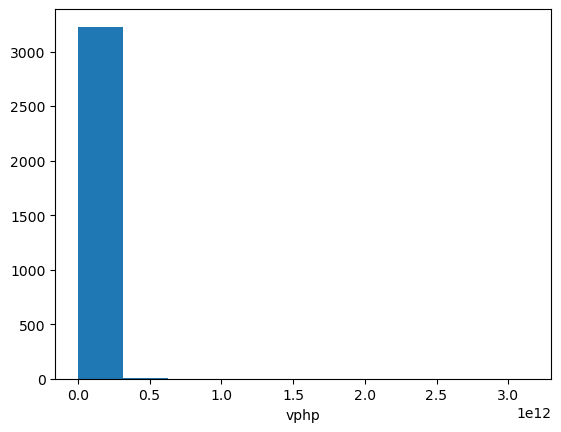

In [53]:
temp_xp.plot.hist();

In [54]:
batch

NameError: name 'batch' is not defined

## The ML part


In [30]:
num_in = batch_out['X'].shape[-1]
num_in

55

In [31]:
ANN_model = ML_classes.PointwiseANN(num_in=num_in,shape=[36,36,2])

In [32]:
ANN_model.count_parameters()

3422


In [33]:
regress_sys = ML_classes.AnnRegressionSystem(ANN_model)

In [34]:
%%time 
regress_sys.train_system(ML_data_combo, num_epoch=21, print_freq=2)

At epoch 1. Train loss :  1.1555536937069248 , Test loss: 0.773603332042694
At epoch 3. Train loss :  0.4342616442087534 , Test loss: 0.3993486225605011
At epoch 5. Train loss :  0.2952044139037261 , Test loss: 0.28364573121070863
At epoch 7. Train loss :  0.24080278543201653 , Test loss: 0.2463202655315399
At epoch 9. Train loss :  0.22929063922650106 , Test loss: 0.23517254292964934
At epoch 11. Train loss :  0.19178743177169078 , Test loss: 0.19806957840919495
At epoch 13. Train loss :  0.18183037115109935 , Test loss: 0.18197887837886811
At epoch 15. Train loss :  0.17379023738809535 , Test loss: 0.18147772252559663
At epoch 17. Train loss :  0.18869074574998906 , Test loss: 0.18371311724185943
At epoch 19. Train loss :  0.1594515551586409 , Test loss: 0.16569618582725526
At epoch 21. Train loss :  0.1568023373146315 , Test loss: 0.15545656383037568
CPU times: user 5min 26s, sys: 34.3 s, total: 6min 1s
Wall time: 1min 41s


In [40]:
%%time 
regress_sys.train_system(ML_data_combo, num_epoch=41, print_freq=2)

At epoch 22. Train loss :  0.1668290689184859 , Test loss: 0.1986052453517914
At epoch 24. Train loss :  0.16105489271718101 , Test loss: 0.19653784930706025
At epoch 26. Train loss :  0.15445821108044805 , Test loss: 0.1955508142709732
At epoch 28. Train loss :  0.1546856317971204 , Test loss: 0.19441333115100862
At epoch 30. Train loss :  0.1551513969898224 , Test loss: 0.19248290061950685
At epoch 32. Train loss :  0.15270047493883082 , Test loss: 0.19511957764625548
At epoch 34. Train loss :  0.14699104347744504 , Test loss: 0.17884911596775055
At epoch 36. Train loss :  0.1415480244401339 , Test loss: 0.17684364020824433
At epoch 38. Train loss :  0.13802803831325994 , Test loss: 0.17715826034545898
At epoch 40. Train loss :  0.13928535500088254 , Test loss: 0.17699914276599885
At epoch 42. Train loss :  0.13560908529404048 , Test loss: 0.17470641136169435
At epoch 44. Train loss :  0.13287203356220917 , Test loss: 0.1719011604785919
At epoch 46. Train loss :  0.13001448439585195 

In [1]:
## Loss plot
plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

plt.grid()
plt.yscale('log')
plt.legend()

NameError: name 'plt' is not defined

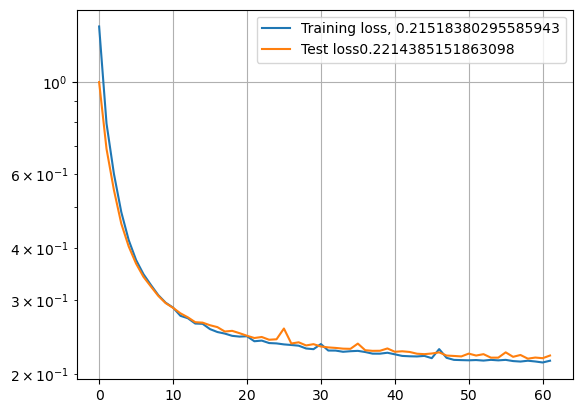

In [100]:
## Loss plot
plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

plt.grid()
plt.yscale('log')
plt.legend()